# Homework 3 Solutions

This example contains figures from Krzysztof Fidkowski's CFD course notes.

In [148]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()


## Problem 1


The continuous PDE we are solving is:

$$-\nabla^2 u = 1$$

To discretise this equation, use the standard 5-point stencil for the Laplacian:

$$\nabla^2 u = \frac{u_{i-1,j} + u_{i+1,j} - 2u_{i,j}}{dx^2} + \frac{u_{i,j-1} + u_{i,j+1} - 2u_{i,j}}{dy^2}$$

Which gives the discretised PDE:

$$-\frac{u_{i-1,j} + u_{i+1,j}}{dx^2} - \frac{u_{i,j-1} + u_{i,j+1}}{dy^2} + 2u_{i,j} \left(\frac{1}{dx^2}+\frac{1}{dy^2}\right) = 1$$

### Part a): Computing the residual

When we a PDE, the error we really care about is the difference between out current guess at the solution, $u$, and the true solution, $u^*$:

$$e = u^* - u$$

However, you don't know $u^*$, so cannot compute $e$, so we need another way to measure the error that we can compute using only our current guess at the solution.

The solution here is to use the **residual**. If we are trying to solve an equation of the form:

$$LHS(u) = RHS$$

Then the residual is simply the difference between the left and right hand sides of the equation:

$$r(u) = LHS(u) - RHS$$

This concept of the residual can be applied to both the continuous and discretised form of the equation. For the continuous equation, the residual is:

$$r(u) = 1 + \nabla^2 u$$

And for the discretised equation, the residual is:

$$r_{i,j} = 1 + \frac{u_{i-1,j} + u_{i+1,j}}{dx^2} + \frac{u_{i,j-1} + u_{i,j+1}}{dy^2} - 2u_{i,j} \left(\frac{1}{dx^2}+\frac{1}{dy^2}\right)$$

In [149]:
def computeResidual(u, dx, dy, rhs, r):
    """Compute the discretised residual for the equation -Laplacian(u) = rhs

    The residual is r = rhs + Laplacian(u)

    The discretised laplacian is:
    laplacian(u) = (u_{i-1,j} + u_{i+1,j} - 2u_{i,j})/dx^2 + (u_{i,j-1} + u_{i,j+1} - 2u_{i,j})/dy^2

    Parameters
    ----------
    u : Nx+1 x Ny+1 array
        State values
    dx : float
        Mesh spacing in x
    dy : float
        mesh spacing in y
    r : Nx+1 x Ny+1 array
        Residual array to be populated
    """
    # Get the entries in the array that correspond to each point in the stencil
    left = u[0:-2, 1:-1]
    right = u[2:, 1:-1]
    centre = u[1:-1, 1:-1]
    up = u[1:-1, 2:]
    down = u[1:-1, 0:-2]

    r[1:-1, 1:-1] = (
        rhs[1:-1, 1:-1]
        + (left + right - 2 * centre) / dx**2
        + (down + up - 2 * centre) / dy**2
    )
    return


def computeNorm(r, ord=2):
    """Compute the "normalized" norm of an array

    Parameters
    ----------
    r : numpy.ndarray
        Vector to compute the norm of
    ord : int, optional
        Order of the norm to compute, by default 2
    """
    rFlat = r.flatten()
    return np.linalg.norm(rFlat / rFlat.size, ord=ord)

def plotField(fig, ax, x, y, z, **kwargs):
    contour = ax.contourf(x, y, z, **kwargs)
    fig.colorbar(contour, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    niceplots.adjust_spines(ax)


In question 1 you're asked to compare the discrete and continuous forms of the residual using the initial guess $u_\text{test}(x,y) = \sin\left(\frac{2\pi x}{L_x}\right)\sin\left(\frac{2\pi y}{L_y}\right)$

The Laplacian of this function is:

$$\nabla^2 u_\text{test} = -4\pi^2 u_\text{test} \left(\frac{1}{L_x^2} + \frac{1}{L_y^2}\right)$$

In [150]:
def computeUTest(X, Y, Lx, Ly):
    """Compute the supplied initial condition at a given set of coordinates

    Parameters
    ----------
    X : numpy ndarray
        x coordinates
    Y : numpy ndarray
        y coordinates

    Returns
    -------
    numpy ndarray
        U value
    """
    return np.sin(2 * np.pi * X / Lx) * np.sin(2 * np.pi * Y / Ly)


def computeUTestLaplacian(X, Y, Lx, Ly):
    """Compute the Laplacian of the supplied initial condition at a given set of coordinates

    Parameters
    ----------
    X : numpy ndarray
        x coordinates
    Y : numpy ndarray
        y coordinates
    """
    return (
        -4
        * np.pi**2
        * (
            np.sin(2 * np.pi * X / Lx) * np.sin(2 * np.pi * Y / Ly) / Lx**2
            + np.sin(2 * np.pi * Y / LY) * np.sin(2 * np.pi * X / Lx) / Ly**2
        )
    )


In [151]:
# --- Define constants ---
LX = 2.0
LY = 1.0
UB = 0.0

# ==============================================================================
# Question 1
# ==============================================================================
# --- Part a) ---
N = 32
dx = LX / N
dy = LY / N


To compute the discrete residual we set the $u_{i,j}$ values at the mesh nodes using $u_\text{test}$, and then use the discrete form of the residual, to compute the residual at each mesh node $r_{i,j}$.

In [152]:
x = np.linspace(0, LX, N + 1)
y = np.linspace(0, LY, N + 1)
XX, YY = np.meshgrid(x, y)
U = computeUTest(XX, YY, LX, LY)
r = np.zeros_like(U)
RHS = np.ones_like(U)
computeResidual(U, dx, dy, RHS, r)


For the continuous residual, we simply substitute $u_\text{test}$ into the continuous residual equation, $r = 1+\nabla^2 u_\text{test}$, and compute this function at each of the mesh nodes:

In [153]:
rExact = np.ones_like(U) + computeUTestLaplacian(XX, YY, LX, LY)


When we compare the two forms of the residual, they should look very similar, provided our mesh is refined enough. If the mesh is not refined enough, then the discrete residual will not be a good approximation to the continuous residual.

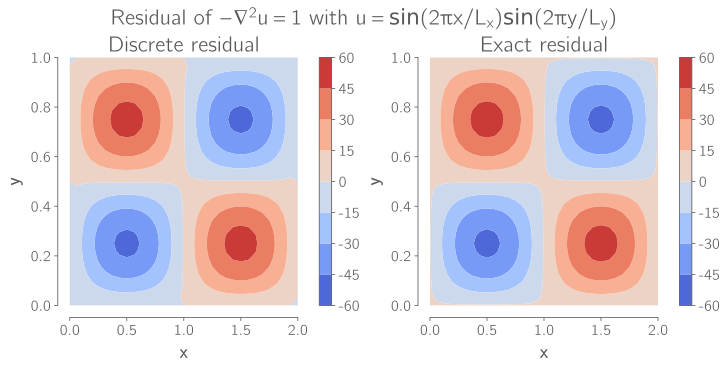

In [154]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

plotField(fig, axes[0], XX, YY, r, cmap="coolwarm")
plotField(fig, axes[1], XX, YY, rExact, cmap="coolwarm")

fig.suptitle(r"Residual of $-\nabla^2u= 1$ with $u=\sin(2\pi x/L_x) \sin(2\pi y/L_y)$")
axes[0].set_title("Discrete residual")
axes[1].set_title("Exact residual")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    niceplots.adjust_spines(ax)


### Part b)

In this question, we take the discrete residual we computed in part a), and restrict it to a coarser mesh, we will use the 2D restriction stencil given in the course notes.

![2D restriction](../../images/Restriction2D.png)

In [155]:
def restrict2D(rFine, rCoarse):
    """Restrict a residual from a fine 2D grid to a coarse 2D grid

    Doesn't populate residuals on the coarse grid boundaries

    Parameters
    ----------
    rFine : Nx+1 x Ny+1 array
        Residual on the fine grid
    rCoarse : Nx/2+1 x Ny/2+1 array
        Array to populate with the restricted residual
    """
    # Get the fine grid residuals surrounding each coarse grid point
    centre = rFine[2:-1:2, 2:-1:2]
    left = rFine[1:-2:2, 2:-1:2]
    right = rFine[3::2, 2:-1:2]
    up = rFine[2:-1:2, 3::2]
    down = rFine[2:-1:2, 1:-2:2]
    upperLeft = rFine[1:-2:2, 3::2]
    upperRight = rFine[3::2, 3::2]
    lowerLeft = rFine[1:-2:2, 1:-2:2]
    lowerRight = rFine[3::2, 1:-2:2]

    rCoarse[1:-1, 1:-1] = (
        0.25 * centre + 1 / 8 * (left + right + up + down) + 1 / 16 * (upperLeft + upperRight + lowerLeft + lowerRight)
    )
    return


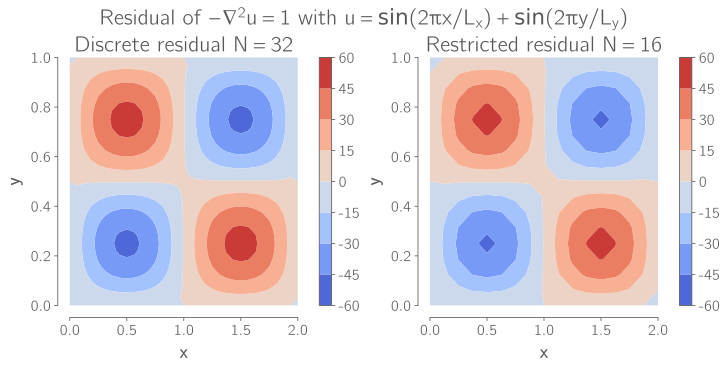

In [156]:
# --- Part b) ---
XXCoarse = XX[0::2, 0::2]
YYCoarse = YY[0::2, 0::2]
rCoarse = np.zeros_like(XXCoarse)
restrict2D(r, rCoarse)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
plotField(fig, axes[0], XX, YY, r, cmap="coolwarm")
plotField(fig, axes[1], XXCoarse, YYCoarse, rCoarse, cmap="coolwarm")
fig.suptitle(r"Residual of $-\nabla^2u= 1$ with $u=\sin(2\pi x/L_x) \sin(2\pi y/L_y)$")
axes[0].set_title(f"Discrete residual $N={N}$")
axes[1].set_title(f"Restricted residual $N={N//2}$")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    niceplots.adjust_spines(ax)


As we might have expected, the restricted residual looks like a lower resolution version of the original residual.

### Part c)

In this question, we compute $u_\text{test}$ on the coarse mesh, and then prolongate it to the fine mesh, we will use the 2D prolongation stencil given in the course notes.

![2D prolongation](../../images/Prolong2D.png)

In multigrid, we will always be adding the prolongated correction to an existing state, so the function I implemented below performs the prolongation and addition in one step.

In [157]:
def addProlongedCorrection2D(duCoarse, uFine):
    """Prolong a correction from a coarse 2D grid to a fine 2D grid and add it to an existing fine grid state

    Doesn't add corrections onto the fine grid boundaries

    Parameters
    ----------
    duCoarse : Nx/2+1 x Ny/2+1 array
        Coarse grid correction
    duFine : Nx+1 x Ny+1 array
        Array to populate with the prolonged correction
    """
    # Centre
    uFine[2:-1:2, 2:-1:2] += duCoarse[1:-1, 1:-1]
    # Left
    uFine[1:-2:2, 2:-1:2] += 0.5 * duCoarse[1:-1, 1:-1]
    # Right
    uFine[3::2, 2:-1:2] += 0.5 * duCoarse[1:-1, 1:-1]
    # Up
    uFine[2:-1:2, 3::2] += 0.5 * duCoarse[1:-1, 1:-1]
    # Down
    uFine[2:-1:2, 1:-2:2] += 0.5 * duCoarse[1:-1, 1:-1]
    # Upper left
    uFine[1:-2:2, 3::2] += 0.25 * duCoarse[1:-1, 1:-1]
    # Upper right
    uFine[3::2, 3::2] += 0.25 * duCoarse[1:-1, 1:-1]
    # Lower left
    uFine[1:-2:2, 1:-2:2] += 0.25 * duCoarse[1:-1, 1:-1]
    # Lower right
    uFine[3::2, 1:-2:2] += 0.25 * duCoarse[1:-1, 1:-1]
    return


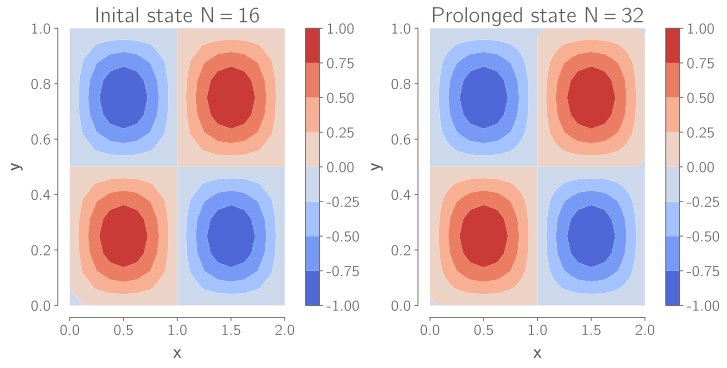

In [158]:
# --- Part c) ---
uCoarse = computeUTest(XXCoarse, YYCoarse, LX, LY)
uProlonged = np.zeros_like(XX)
addProlongedCorrection2D(uCoarse, uProlonged)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
plotField(fig, axes[0], XXCoarse, YYCoarse, uCoarse, cmap="coolwarm")
plotField(fig, axes[1], XX, YY, uProlonged, cmap="coolwarm")
axes[0].set_title(f"Inital state $N={N//2}$")
axes[1].set_title(f"Prolonged state $N={N}$")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    niceplots.adjust_spines(ax)


The prolongated state should look almost exactly the same as the coarse mesh state because the prolongation is a simple linear interpolation.

## Problem 2

In [159]:
from functools import lru_cache

# This lru_cache decorator means that python will save the results of this function in memory so it doesn't need to
# recompute them if the function is called again with the same inputs
@lru_cache()
def getRedBlackInds(Nx, Ny):
    redXInds = []
    redYInds = []
    blackXInds = []
    blackYInds = []
    for x in range(1, Nx):
        for y in range(1, Ny):
            if (x + y) % 2 == 0:
                redXInds.append(x)
                redYInds.append(y)
            else:
                blackXInds.append(x)
                blackYInds.append(y)
    return (
        np.array(redXInds, dtype=int),
        np.array(redYInds, dtype=int),
        np.array(blackXInds, dtype=int),
        np.array(blackYInds, dtype=int),
    )

def gaussSeidelIteration(u, dx, dy, RHS, Nx, Ny, omega=1.0):
    # Figure out the red nodes and the black nodes
    redXInds, redYInds, blackXInds, blackYInds = getRedBlackInds(Nx, Ny)

    # Precompute some of the values used in the update equation for neatness
    dx2inv = 1 / dx**2
    dy2inv = 1 / dy**2
    factor = 1 / (2 * (dx2inv + dy2inv))

    # Update red nodes
    res = RHS[redXInds, redYInds]
    left = u[redXInds - 1, redYInds]
    right = u[redXInds + 1, redYInds]
    up = u[redXInds, redYInds + 1]
    down = u[redXInds, redYInds - 1]

    u[redXInds, redYInds] = (
        omega * (factor * (res + dx2inv * (left + right) + dy2inv * (up + down))) + (1 - omega) * u[redXInds, redYInds]
    )

    # Update black nodes
    res = RHS[blackXInds, blackYInds]
    left = u[blackXInds - 1, blackYInds]
    right = u[blackXInds + 1, blackYInds]
    up = u[blackXInds, blackYInds + 1]
    down = u[blackXInds, blackYInds - 1]

    u[blackXInds, blackYInds] = (
        omega * (factor * (res + dx2inv * (left + right) + dy2inv * (up + down)))
        + (1 - omega) * u[blackXInds, blackYInds]
    )
    return

def iterativeSolve(u, dx, dy, smootherFunc, omega=1.0, tol=1e-4, maxIter=100):
    resNormHistory = []
    iterationTimes = []
    printFrequency = max(1, maxIter // 10)
    uSol = np.copy(u)
    Nx = u.shape[0] - 1
    Ny = u.shape[1] - 1
    RHS = np.ones_like(u)
    res = np.zeros_like(u)

    startTime = time.time()
    for ii in range(maxIter):
        computeResidual(uSol, dx, dy, RHS, res)
        resNorm = computeNorm(res, ord=1)
        if ii % printFrequency == 0:
            print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
        resNormHistory.append(resNorm)
        iterationTimes.append(time.time() - startTime)
        if resNorm < tol or resNorm > 1e10 or np.isnan(resNorm):
            break
        smootherFunc(uSol, dx, dy, RHS, Nx, Ny, omega=omega)

    if ii % printFrequency != 0:
        print(f"Iteration {ii}: Res norm = {resNorm:.2e}")
    return uSol, np.array(resNormHistory), np.array(iterationTimes)


Iteration 0: Res norm = 8.82e-01
Iteration 20: Res norm = 5.78e-01
Iteration 40: Res norm = 4.51e-01
Iteration 60: Res norm = 3.63e-01
Iteration 80: Res norm = 2.95e-01
Iteration 100: Res norm = 2.41e-01
Iteration 120: Res norm = 1.97e-01
Iteration 140: Res norm = 1.62e-01
Iteration 160: Res norm = 1.33e-01
Iteration 180: Res norm = 1.09e-01
Iteration 199: Res norm = 9.09e-02
Iteration 0: Res norm = 8.82e-01
Iteration 20: Res norm = 1.12e+00
Iteration 40: Res norm = 6.01e-01
Iteration 60: Res norm = 3.29e-01
Iteration 80: Res norm = 1.82e-01
Iteration 100: Res norm = 1.01e-01
Iteration 120: Res norm = 5.57e-02
Iteration 140: Res norm = 3.08e-02
Iteration 160: Res norm = 1.71e-02
Iteration 180: Res norm = 9.45e-03
Iteration 199: Res norm = 5.39e-03
Iteration 0: Res norm = 8.82e-01
Iteration 20: Res norm = 1.29e+00
Iteration 40: Res norm = 3.86e-01
Iteration 60: Res norm = 1.17e-01
Iteration 80: Res norm = 3.56e-02
Iteration 100: Res norm = 1.08e-02
Iteration 120: Res norm = 3.28e-03
Ite

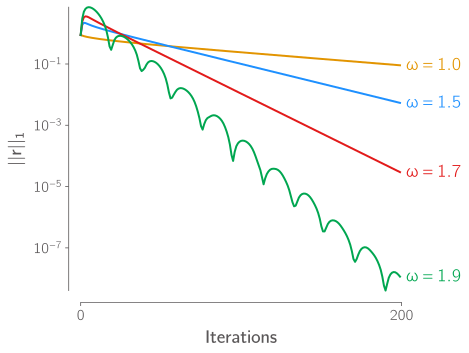

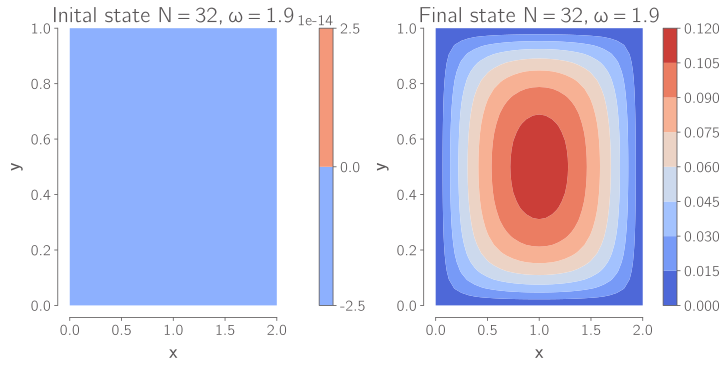

In [160]:
# ==============================================================================
# Question 2
# ==============================================================================
maxIter = 200

# --- Trying different relaxation factors ---
omegas = [1.0, 1.5, 1.7, 1.9]
omegaFig, omegaAx = plt.subplots()
omegaAx.set_yscale("log")
omegaAx.set_xlabel("Iterations")
omegaAx.set_ylabel("$||r||_1$")

U = np.zeros((N + 1, N + 1))

for omega in omegas:
    USol, resHistory, iterTimes = iterativeSolve(
        U, dx, dy, gaussSeidelIteration, omega=omega, tol=1e-16, maxIter=maxIter
    )
    omegaAx.plot(resHistory, label=f"$\omega={omega}$", clip_on=False)

omegaAx.set_xticks([0, maxIter])
niceplots.adjust_spines(omegaAx)
niceplots.label_line_ends(omegaAx)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
plotField(fig, axes[0], XX, YY, U, cmap="coolwarm")
plotField(fig, axes[1], XX, YY, USol, cmap="coolwarm")
axes[0].set_title(f"Inital state $N={N}, \omega={omega}$")
axes[1].set_title(f"Final state $N={N}, \omega={omega}$")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    niceplots.adjust_spines(ax)


As we expect, increasing $\omega$ increases the convergence rate. However, at $\omega=1.9$ we see some oscillations in the error, which suggests we are approaching the stability limit of the solver.

Iteration 0: Res norm = 1.71e+01
Iteration 20: Res norm = 7.75e-02
Iteration 40: Res norm = 1.14e-05
Iteration 60: Res norm = 4.93e-08
Iteration 80: Res norm = 9.70e-12
Iteration 100: Res norm = 3.23e-14
Iteration 120: Res norm = 5.38e-15
Iteration 140: Res norm = 5.67e-15
Iteration 160: Res norm = 6.00e-15
Iteration 180: Res norm = 5.36e-15
Iteration 199: Res norm = 6.29e-15
Iteration 0: Res norm = 1.87e+01
Iteration 20: Res norm = 1.29e+00
Iteration 40: Res norm = 3.86e-01
Iteration 60: Res norm = 1.17e-01
Iteration 80: Res norm = 3.56e-02
Iteration 100: Res norm = 1.08e-02
Iteration 120: Res norm = 3.28e-03
Iteration 140: Res norm = 9.96e-04
Iteration 160: Res norm = 3.02e-04
Iteration 180: Res norm = 9.18e-05
Iteration 199: Res norm = 2.96e-05
Iteration 0: Res norm = 1.94e+01
Iteration 20: Res norm = 4.01e+01
Iteration 40: Res norm = 1.23e+01
Iteration 60: Res norm = 4.00e+00
Iteration 80: Res norm = 1.59e+00
Iteration 100: Res norm = 9.47e-01
Iteration 120: Res norm = 7.11e-01
Ite

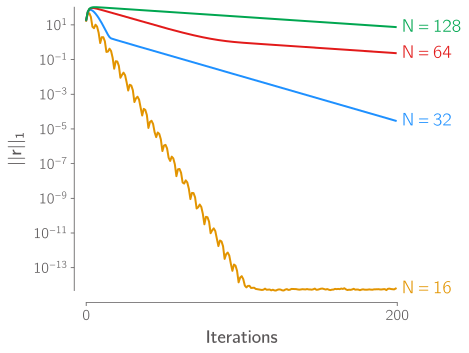

In [161]:
# --- Trying different grid sizes ---
Ns = [16, 32, 64, 128]
nFig, nAx = plt.subplots()
nAx.set_yscale("log")
nAx.set_xlabel("Iterations")
nAx.set_ylabel("$||r||_1$")

for N in Ns:
    x = np.linspace(0, LX, N + 1)
    y = np.linspace(0, LY, N + 1)
    XX, YY = np.meshgrid(x, y)
    dx = LX / N
    dy = LY / N
    U = computeUTest(XX, YY, LX, LY)
    USol, resHistory, iterTimes = iterativeSolve(
        U, dx, dy, gaussSeidelIteration, omega=1.7, tol=1e-16, maxIter=maxIter
    )
    nAx.plot(resHistory, label=f"$N={N}$", clip_on=False)

nAx.set_xticks([0, maxIter])
niceplots.adjust_spines(nAx)
niceplots.label_line_ends(nAx)
plt.show()


The main takeaway here is that the rate of convergence decreases dramatically as we make the mesh finer. So not only is each iteration more expensive, but we need to do more iterations to converge to the same tolerance.

## Problem 3

![Full V Cycle](../../images/MultigridVCycle.png)

On the left side of the V:

1. Smooth $A_h u_h = f_h$ on the fine mesh
2. Compute the residual $r_h = f_h - A_h u_h$
3. Restrict the residual to the coarse mesh $f_{2h} = \text{restrict}(r_h)$
4. Smooth $A_{2h} u_{2h} = f_{2h}$ on the coarse mesh, starting from $u_{2h}=0$
5. Compute the residual $r_{2h} = f_{2h} - A_{2h} u_{2h}$
6. Restrict the residual to the next coarse mesh $f_{4h} = \text{restrict}(r_{2h})$

And so on until we reach the coarsest mesh.

On the right side of the V:

1. Prolongate the correction from the coarsest level to the next coarsest level $u_{4h} = u_{4h} + \text{prolongate}(u_{8h})$
2. Continue smoothing $A_{4h} u_{4h} = f_{4h}$ 
3. Prolongate the correction to the next coarsest level $u_{2h} = u_{2h} + \text{prolongate}(u_{4h})$
4. Continue smoothing $A_{2h} u_{2h} = f_{2h}$
5. Prolongate the correction to the fine mesh $u_{h} = u_{h} + \text{prolongate}(u_{2h})$
6. Continue smoothing $A_{h} u_{h} = f_{h}$

In [162]:
def multigridIteration(u, dx, dy, RHS, Nx, Ny, omega, numPreIter=2, numPostIter=2, numCoarseIter=1):
    # Create lists from storing things that we need at each level
    states = [u]
    rightHandSides = [RHS]
    dxs = [dx]
    dys = [dy]
    Nxs = [Nx]
    Nys = [Ny]

    # Keep creating new levels until we get to the coarsest possible grid (N=2)
    while Nxs[-1] > 2 and Nys[-1] > 2:
        dxs.append(dxs[-1] * 2)
        dys.append(dys[-1] * 2)
        Nxs.append(Nxs[-1] // 2)
        Nys.append(Nys[-1] // 2)
        states.append(np.zeros((Nxs[-1] + 1, Nys[-1] + 1)))
        rightHandSides.append(np.zeros((Nxs[-1] + 1, Nys[-1] + 1)))

    nLevels = len(states)

    # --- Go down the V, starting at level 0 ---
    for level in range(nLevels - 1):

        # Presmooth on current grid
        for _ in range(numPreIter):
            gaussSeidelIteration(
                states[level], dxs[level], dys[level], rightHandSides[level], Nxs[level], Nys[level], omega
            )

        # Compute residual, r = RHS - Au
        currentRes = np.zeros_like(rightHandSides[level])
        computeResidual(states[level], dxs[level], dys[level], rightHandSides[level], currentRes)

        # restrict to next level
        restrict2D(currentRes, rightHandSides[level + 1])

    # --- Now we're at the coarsest grid, do smoothing here ---
    for _ in range(numCoarseIter):
        gaussSeidelIteration(states[-1], dxs[-1], dys[-1], rightHandSides[-1], Nxs[-1], Nys[-1], omega)

    # We're at the coarsest grid level and have smoothing there. Now we go back up the ladder, starting at level N-1:
    for level in np.flip(np.arange(nLevels - 1)):

        # Prolongate the state from the previous level and add it to the current state
        addProlongedCorrection2D(states[level + 1], states[level])

        # Postsmooth on current grid
        for _ in range(numPostIter):
            gaussSeidelIteration(
                states[level], dxs[level], dys[level], rightHandSides[level], Nxs[level], Nys[level], omega
            )

    return


Iteration 0: Res norm = 7.79e-01
Iteration 2: Res norm = 4.33e-03
Iteration 4: Res norm = 7.92e-05
Iteration 6: Res norm = 1.62e-06
Iteration 8: Res norm = 3.30e-08
Iteration 10: Res norm = 6.73e-10
Iteration 12: Res norm = 1.40e-11
Iteration 14: Res norm = 2.93e-13
Iteration 16: Res norm = 7.80e-15
Iteration 18: Res norm = 1.83e-15
Iteration 19: Res norm = 2.40e-15
Iteration 0: Res norm = 8.82e-01
Iteration 2: Res norm = 6.26e-03
Iteration 4: Res norm = 1.53e-04
Iteration 6: Res norm = 4.41e-06
Iteration 8: Res norm = 1.29e-07
Iteration 10: Res norm = 3.85e-09
Iteration 12: Res norm = 1.14e-10
Iteration 14: Res norm = 3.36e-12
Iteration 16: Res norm = 1.04e-13
Iteration 18: Res norm = 1.18e-14
Iteration 19: Res norm = 1.06e-14
Iteration 0: Res norm = 9.39e-01
Iteration 2: Res norm = 7.77e-03
Iteration 4: Res norm = 2.25e-04
Iteration 6: Res norm = 7.14e-06
Iteration 8: Res norm = 2.42e-07
Iteration 10: Res norm = 8.57e-09
Iteration 12: Res norm = 3.02e-10
Iteration 14: Res norm = 1.06

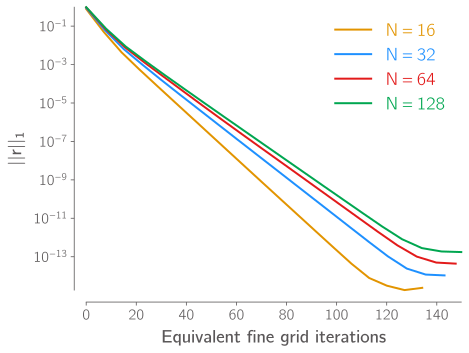

In [163]:
# ==============================================================================
# Question 3
# ==============================================================================

omega = 1.0
maxIter = 20
numPreIter = 2
numPostIter = 2
numCoarseIter = 1

multigridFig, multigridAx = plt.subplots()
multigridAx.set_yscale("log")
multigridAx.set_xlabel("Equivalent fine grid iterations")
multigridAx.set_ylabel("$||r||_1$")

multigridSmoother = lambda u, dx, dy, RHS, Nx, Ny, omega: multigridIteration(
    u, dx, dy, RHS, Nx, Ny, omega, numPreIter=2, numPostIter=2, numCoarseIter=1
)

for N in Ns:
    x = np.linspace(0, LX, N + 1)
    y = np.linspace(0, LY, N + 1)
    XX, YY = np.meshgrid(x, y)
    dx = LX / N
    dy = LY / N
    U = np.zeros((N + 1, N + 1))
    numLevels = int(np.log2(N))
    workPerIteration = numCoarseIter / (2**numLevels)
    for level in range(numLevels - 1):
        workPerIteration += (numPreIter + numPostIter) / (2**level)
    USol, resHistory, iterTimes = iterativeSolve(
        U, dx, dy, multigridSmoother, omega=omega, tol=1e-16, maxIter=maxIter
    )
    work = np.arange(len(resHistory)) * workPerIteration
    multigridAx.plot(work, resHistory, label=f"$N={N}$", clip_on=False)

niceplots.adjust_spines(multigridAx)
multigridAx.legend(labelcolor="linecolor")

plt.show()


Clearly, multigrid is much faster to converge than the Gauss-Seidel smoother. 

The most important to note however, is that the number of iterations required to converge is independent of the mesh size. 
Clearly in this case, the number of iterations is not completely independent, but as the mesh size increases, the number of iterations required to converge the solution is converging to a constant value.